In [20]:
from tsai.all import *
import sklearn.metrics as skm

from IPython.display import clear_output
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [21]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)

data.tail()

,time,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,rmssd,sleep_state
18572996,2022-03-24 12:10:23.257,-2189.5,167.0,3401.0,18.0,-225.0,65.0,-7.840528,NaN,2.0
18572997,2022-03-24 12:10:23.258,-2191.0,163.0,3402.0,22.0,-229.0,58.0,-8.442375,NaN,2.0
18572998,2022-03-24 12:10:23.297,-2188.5,162.0,3404.0,21.0,-229.5,55.5,-9.351681,NaN,2.0
18572999,2022-03-24 12:10:23.298,-2186.0,161.0,3406.0,20.0,-230.0,53.0,-10.222269,NaN,2.0
18573000,2022-03-24 12:10:23.337,-2187.0,164.5,3402.5,20.5,-224.0,50.5,-10.753995,55.922024,2.0


In [22]:
df = data.copy()

df = df[df.sleep_state != -1]

# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.fillna(method='bfill', limit=3000).dropna()

# set column time as datetime index
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time', drop=True)


In [23]:
df = ((df + df.shift(-1)) / 2)[::2]


# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.dropna()

df

,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,rmssd,sleep_state
time,,,,,,,,,
2022-02-16 06:08:11.005,57.00,296.250000,4021.000000,-201.750000,-47.750000,99.00,-5.253603,108.529827,0
2022-02-16 06:08:11.045,29.00,302.500000,4026.000000,-226.250000,-75.250000,119.75,-9.819916,108.529827,0
2022-02-16 06:08:11.085,40.50,310.250000,4031.000000,-228.000000,-108.250000,113.25,-12.173856,108.529827,0
2022-02-16 06:08:11.125,53.50,310.000000,4028.000000,-224.500000,-86.000000,101.25,-9.391197,108.529827,0
2022-02-16 06:08:11.165,45.25,307.250000,4026.750000,-232.000000,-86.250000,116.50,-2.223607,108.529827,0
...,...,...,...,...,...,...,...,...,...
2022-03-24 12:10:23.139,-2180.00,162.000000,3403.500000,9.000000,-219.500000,53.50,-5.481928,55.922024,1
2022-03-24 12:10:23.178,-2183.00,161.833333,3403.333333,4.833333,-220.166667,69.50,-7.442683,55.922024,1
2022-03-24 12:10:23.218,-2187.00,169.166667,3400.666667,12.166667,-220.833333,71.50,-7.740967,55.922024,1


In [24]:
# Non null values in the dataset
df.isnull().sum()

accelerometerX    0
accelerometerY    0
accelerometerZ    0
gyroscopeX        0
gyroscopeY        0
gyroscopeZ        0
ledGreen          0
rmssd             0
sleep_state       0
dtype: int64

In [25]:
class_map = {
    0: 'WK',  # wake
    1: 'SL',  # sleep
}
class_map

{0: 'WK', 1: 'SL'}

<AxesSubplot:xlabel='time'>

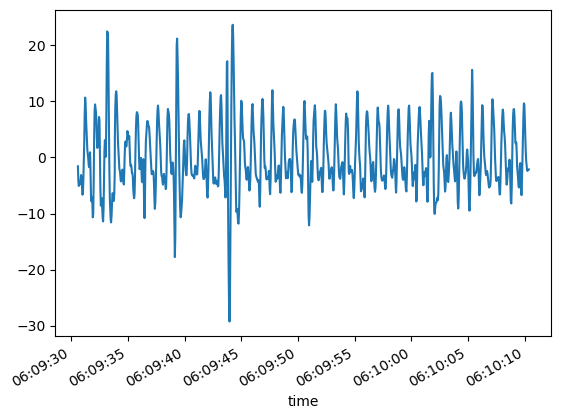

In [26]:
df['ledGreen'][2000:3000].plot()

# Filters and transforms

## TSData preparation

## Data from 3d array

In [27]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = StandardScaler()
le = LabelEncoder()

temp_df = df[['accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'ledGreen', 'rmssd', 'sleep_state']]
X = scaler.fit_transform(temp_df.drop('sleep_state', axis=1))
y = le.fit_transform(temp_df['sleep_state'])

# selecting sequences range
X = X[0:(len(X) - len(X)%1500)]
y = y[0:(len(y) - len(y)%1500)]

pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,-0.878955,0.494040,1.522683,-0.352630,0.243420,0.051745,-0.193422,0.052433
1,-0.893255,0.503237,1.524345,-0.421375,0.189092,0.103968,-0.361426,0.052433
2,-0.887382,0.514640,1.526007,-0.426285,0.123899,0.087609,-0.448032,0.052433
3,-0.880742,0.514272,1.525010,-0.416465,0.167855,0.057407,-0.345653,0.052433
4,-0.884956,0.510226,1.524595,-0.437509,0.167361,0.095789,-0.081943,0.052433
...,...,...,...,...,...,...,...,...
7976995,-2.028818,0.312325,1.314283,0.209255,-0.121069,-0.050815,-0.283241,-0.663249
7976996,-2.025754,0.279955,1.316942,0.269583,-0.106253,-0.039490,-0.359490,-0.663249
7976997,-2.028052,0.292462,1.315779,0.288523,-0.055876,-0.037602,-0.515551,-0.663249
7976998,-2.028435,0.296140,1.314865,0.285015,-0.057358,-0.057737,-0.681873,-0.663249


In [28]:
# epoch lenght 60 seconds (25hz * 60 = 1500)
# 12241 epochs
sht = len(X) // 1500
print("Shape: ", sht)

X = X.T.reshape(sht, 8, 1500)
y = y.T.reshape(sht, 1500)
y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

X.shape, y.shape

Shape:  5318


((5318, 8, 1500), (5318,))

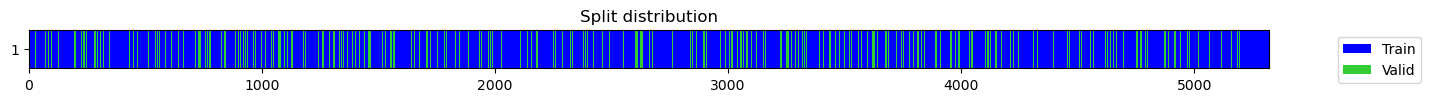

((#4255) [3098,450,2173,1514,221,4850,285,4840,1172,4071...],
 (#1063) [4210,4676,2356,800,5116,1871,4556,2578,440,3160...])

In [29]:
splits = get_splits(y,
                    valid_size=.2,
                    stratify=True,
                    random_state=1223,
                    shuffle=True)
splits

In [30]:
labeler = ReLabeler(class_map)
new_y = labeler(y) # map to more descriptive labels

X.shape, new_y.shape, splits, new_y

((5318, 8, 1500),
 (5318,),
 ((#4255) [3098,450,2173,1514,221,4850,285,4840,1172,4071...],
  (#1063) [4210,4676,2356,800,5116,1871,4556,2578,440,3160...]),
 array(['WK', 'WK', 'WK', ..., 'SL', 'SL', 'SL'], dtype='<U2'))

In [31]:
label_counts = collections.Counter(new_y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'WK': 1897, 'SL': 3421}
Naive Accuracy: 64.33%


In [32]:
tfms = [None, [TSClassification()]]  # TSClassification == Categorize
batch_tfms = TSStandardize()

## Dataloaders

In [33]:
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

(#4255) [(TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:1500, device=cpu, dtype=torch.float32), TensorCategory(1))] ...]

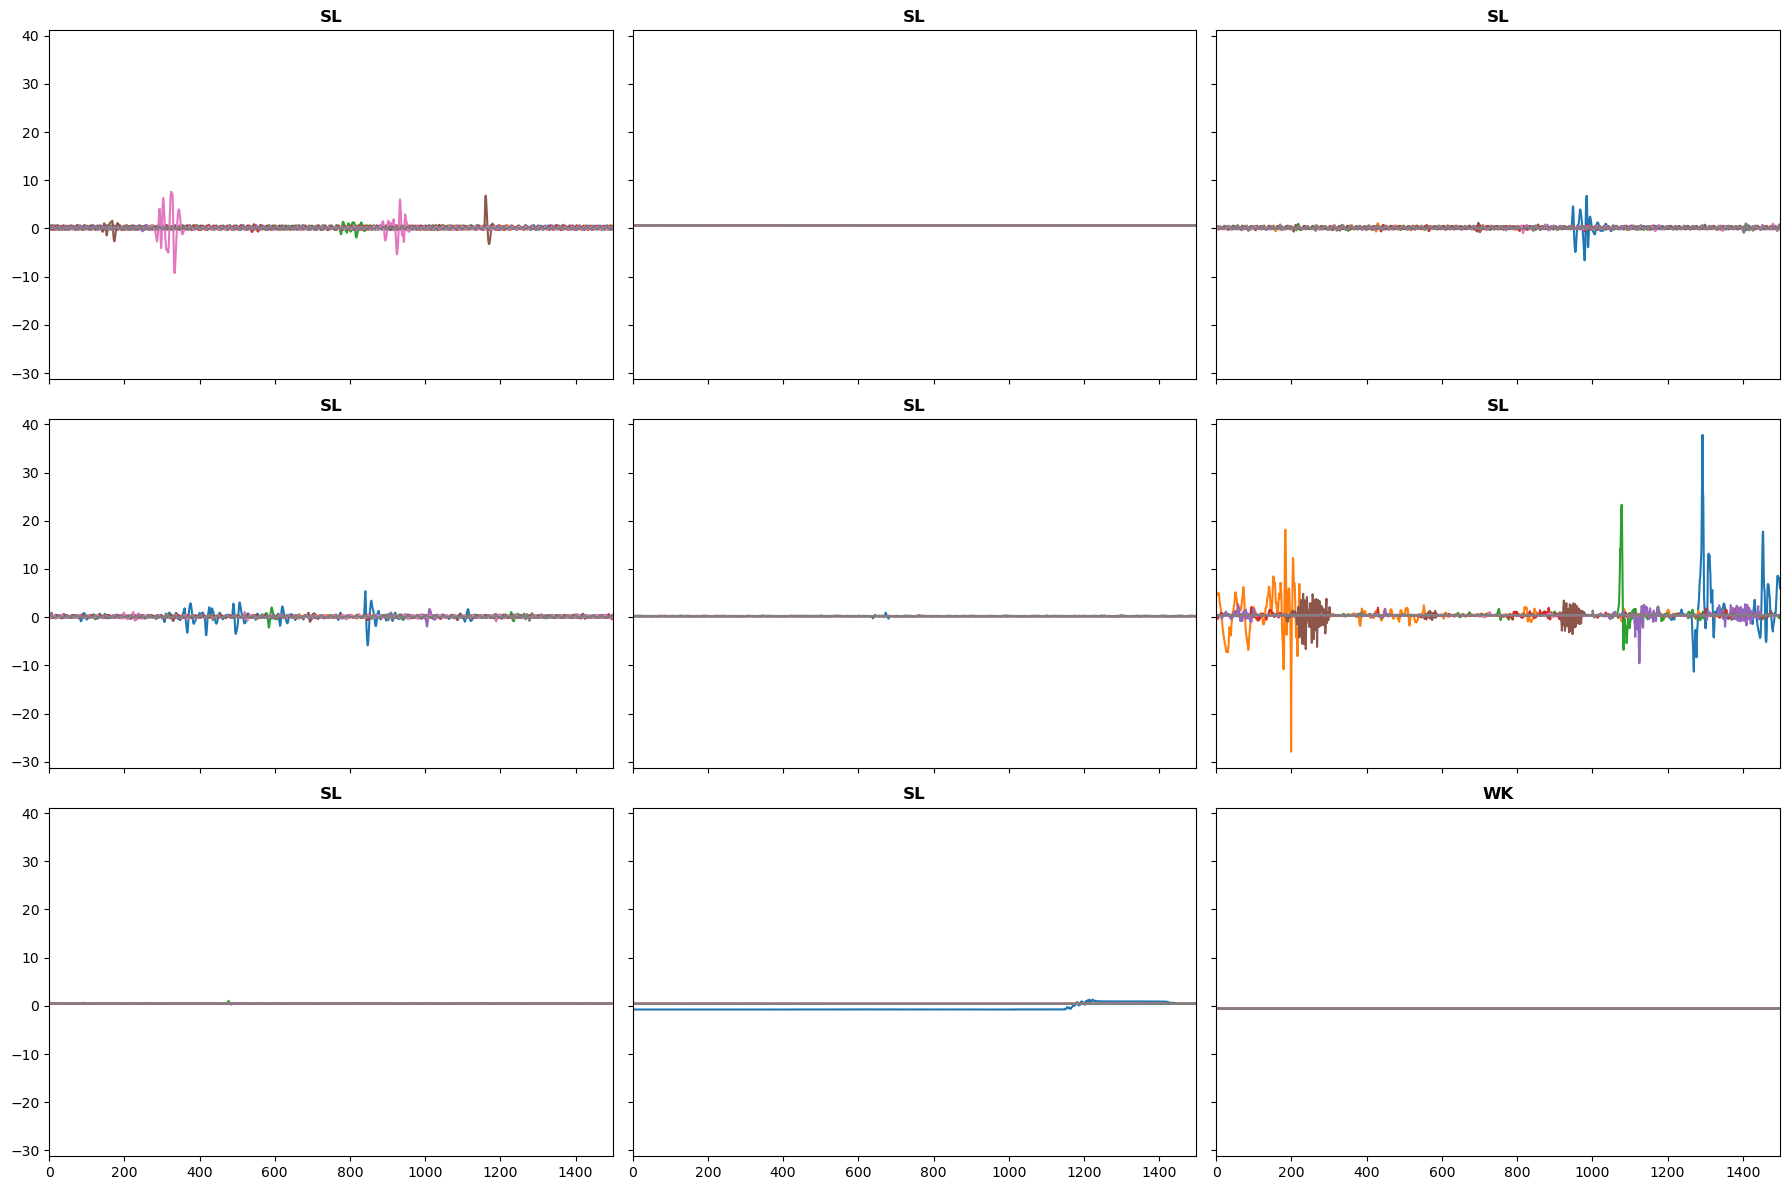

In [34]:
dls.show_batch(sharey=True)

## Build learner

In [35]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}),
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]


# for i, (arch, k) in enumerate(archs):
#     print(f'arch: {arch.__name__}')

# results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
# for i, (arch, k) in enumerate(archs):
#     model = build_ts_model(arch, dls=dls, **k)
#     print(model.__class__.__name__)
#     learn = ts_learner(dls, model,  metrics=[accuracy, Precision(), Recall(), F1Score()])
#     start = time.time()
#     learn.fit_one_cycle(30, 1e-3)
#     elapsed = time.time() - start
#     vals = learn.recorder.values[-1]
#     results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
#     results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
#     clear_output()
#     display(results)

In [36]:
metrics = [accuracy, Precision(), Recall(), F1Score()]

model = build_ts_model(LSTM_FCN, dls=dls, shuffle=False)
# model = build_ts_model(InceptionTimePlus, dls=dls)

learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())

In [37]:
# learn = Learner(dls, model, metrics=accuracy)

## LR find

SuggestedLRs(valley=0.0020892962347716093)

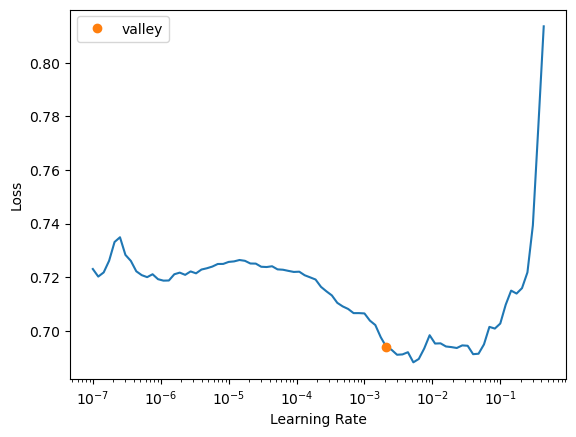

In [38]:
# learn.load('stage0')
learn.lr_find()

## Learner feature importance

X.shape: (4255, 8, 1500)
y.shape: (4255,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.458989


  0 feature: var_0                accuracy: 0.456169


  1 feature: var_1                accuracy: 0.381904


  2 feature: var_2                accuracy: 0.400000


  3 feature: var_3                accuracy: 0.432432


  4 feature: var_4                accuracy: 0.419977


  5 feature: var_5                accuracy: 0.355582


  6 feature: var_6                accuracy: 0.381904


  7 feature: var_7                accuracy: 0.408931



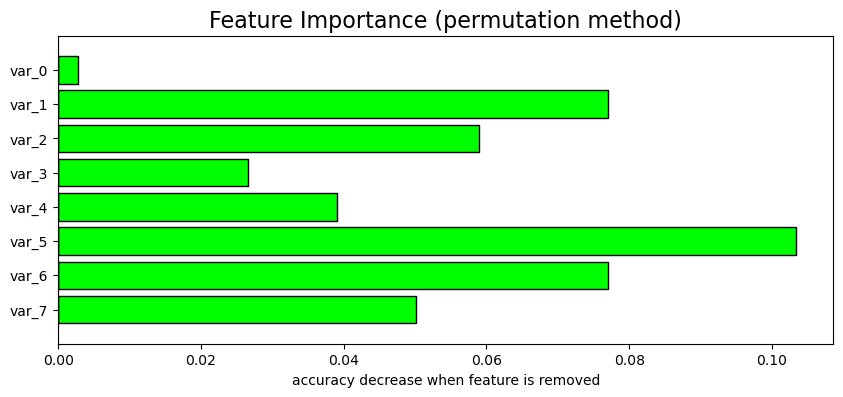

,Feature,accuracy,accuracy_change
0,var_5,0.355582,0.103408
1,var_1,0.381904,0.077086
2,var_6,0.381904,0.077086
3,var_2,0.400000,0.058989
4,var_7,0.408931,0.050059
5,var_4,0.419977,0.039013
6,var_3,0.432432,0.026557
7,var_0,0.456169,0.002820
8,BASELINE,0.458989,-0.000000


In [39]:
learn.feature_importance()

In [40]:
# learn.step_importance()

Before temperature - NLL: 0.696, ECE: 0.037
Calibrating the model...
...model calibrated
Optimal temperature: 1.023
After temperature  - NLL: 0.696, ECE: 0.037



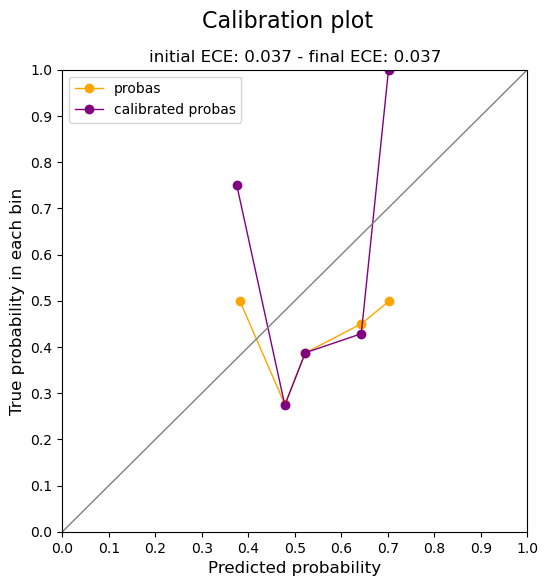

In [41]:
learn.calibrate_model()

# Fit model

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.674466,0.640934,0.648166,0.543860,0.081794,0.142202,00:11
1,0.648108,0.641319,0.642521,0.485714,0.044855,0.082126,00:11
2,0.642501,0.640375,0.657573,0.608696,0.110818,0.187500,00:11
3,0.639812,0.634078,0.639699,0.458333,0.058047,0.103044,00:11
4,0.641141,0.641812,0.643462,0.500000,0.137203,0.215321,00:11
5,0.637504,0.634233,0.655691,0.597015,0.105541,0.179372,00:11
6,0.634842,0.634299,0.652869,0.578125,0.097625,0.167043,00:11
7,0.630877,0.637721,0.656632,0.616667,0.097625,0.168565,00:11
8,0.635250,0.638456,0.655691,0.563107,0.153034,0.240664,00:11
9,0.634138,0.640162,0.656632,0.634615,0.087071,0.153132,00:11


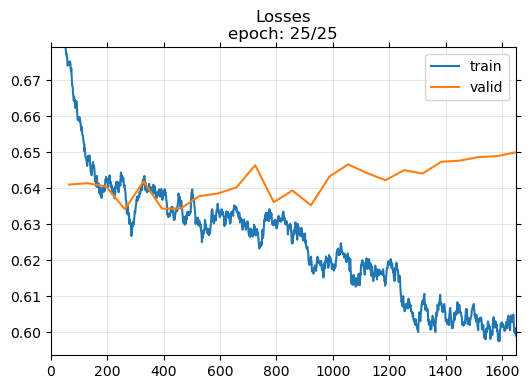

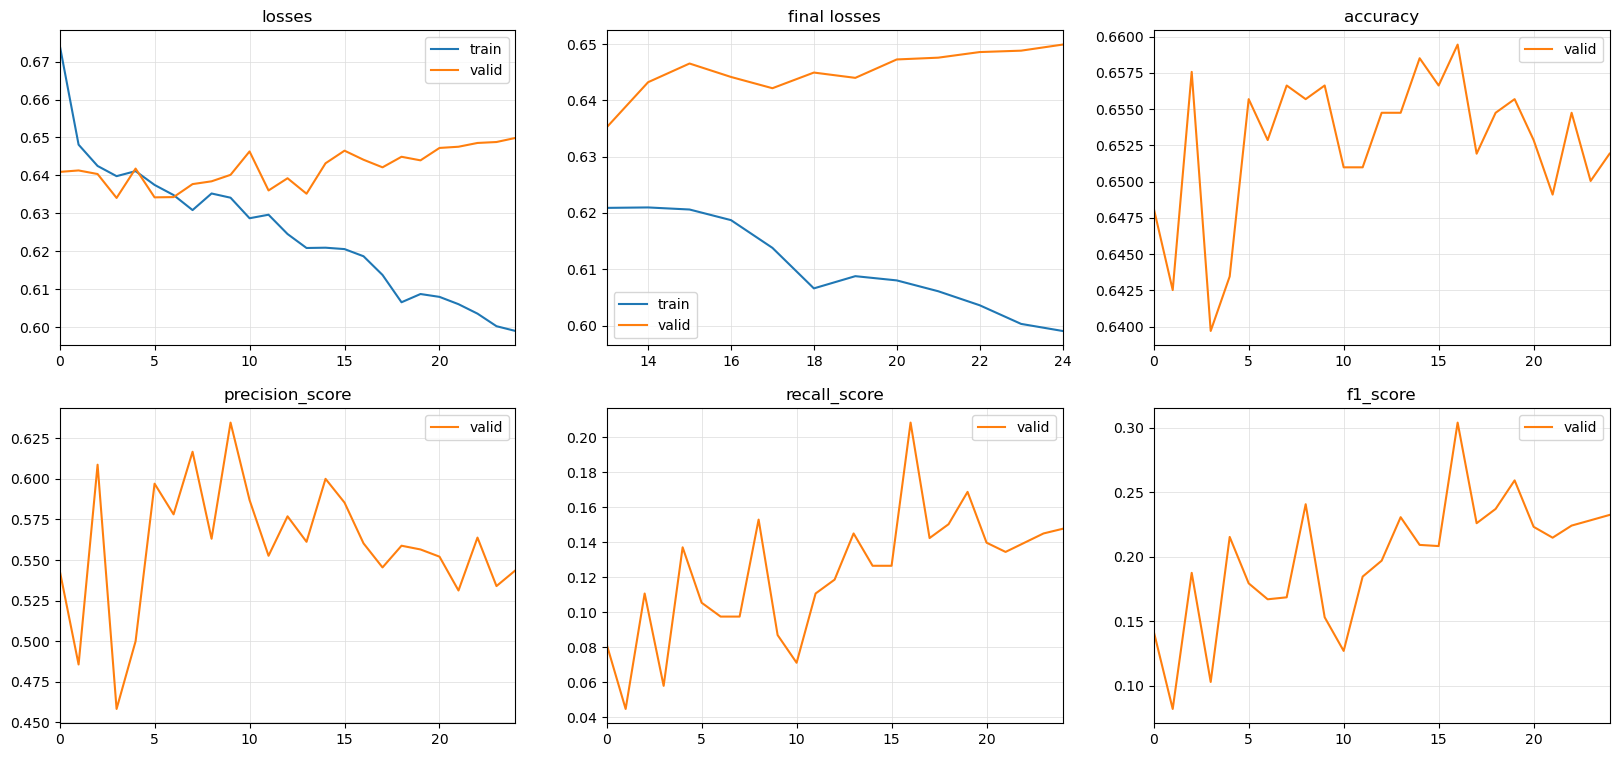

In [42]:
learn.fit_one_cycle(25, lr_max=1e-3)

In [43]:
# learn.fit_flat_cos(10, 0.025)

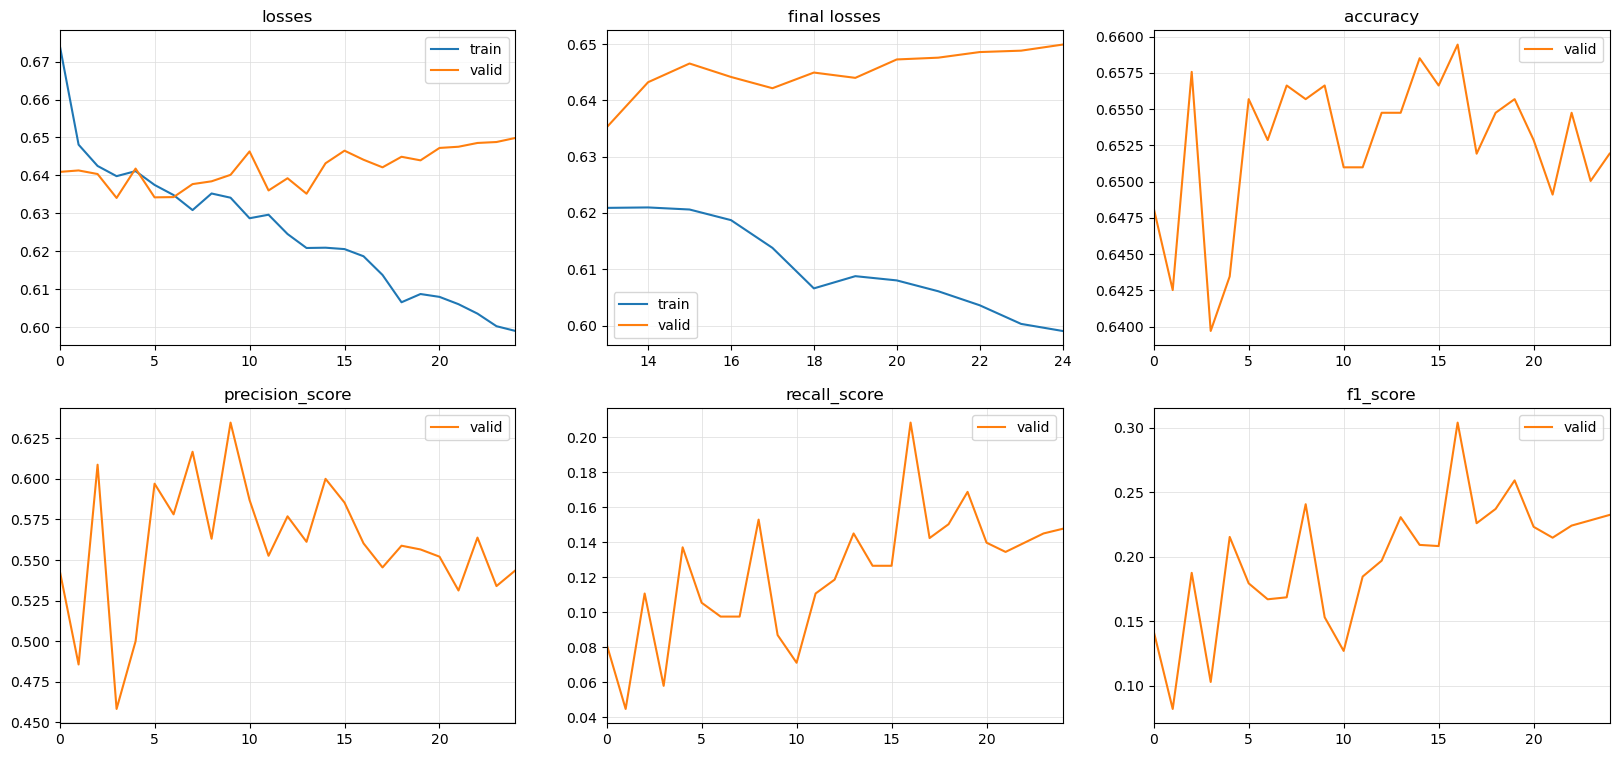

In [44]:
learn.plot_metrics()

## Transformers 

In [45]:
# model = TST(dls.vars, dls.c, dls.len, dropout=.3)
# learn = Learner(dls,
#                 model,
#                 loss_func=LabelSmoothingCrossEntropyFlat(),
#                 metrics=[RocAucBinary(), accuracy],
#                 cbs=ShowGraphCallback2())
# start = time.time()
# learn.fit_one_cycle(25, lr_max=1e-4)
# print('\nElapsed time:', time.time() - start)
# learn.plot_metrics()
# beep()

##### Save model

In [46]:
learn.save('rmmsd')

Path('models/rmmsd.pth')

In [47]:
learn.save_all(path='export_rmmsd',
               dls_fname='dls',
               model_fname='model',
               learner_fname='learner')

## Inferece


In [48]:
# learn = load_learner_all(path='export_rmmsd',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:8, len:1500, device=cuda:0, dtype=torch.float32),
 TensorCategory([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
         1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
         1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0'))

In [49]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[0.7796, 0.2204],
         [0.4938, 0.5062],
         [0.7059, 0.2941],
         ...,
         [0.6102, 0.3898],
         [0.6309, 0.3691],
         [0.4851, 0.5149]]),
 tensor([1, 1, 0,  ..., 1, 0, 0]),
 tensor([0, 1, 0,  ..., 0, 0, 1]))

In [50]:
(valid_targets == valid_preds).float().mean()

tensor(0.6519)

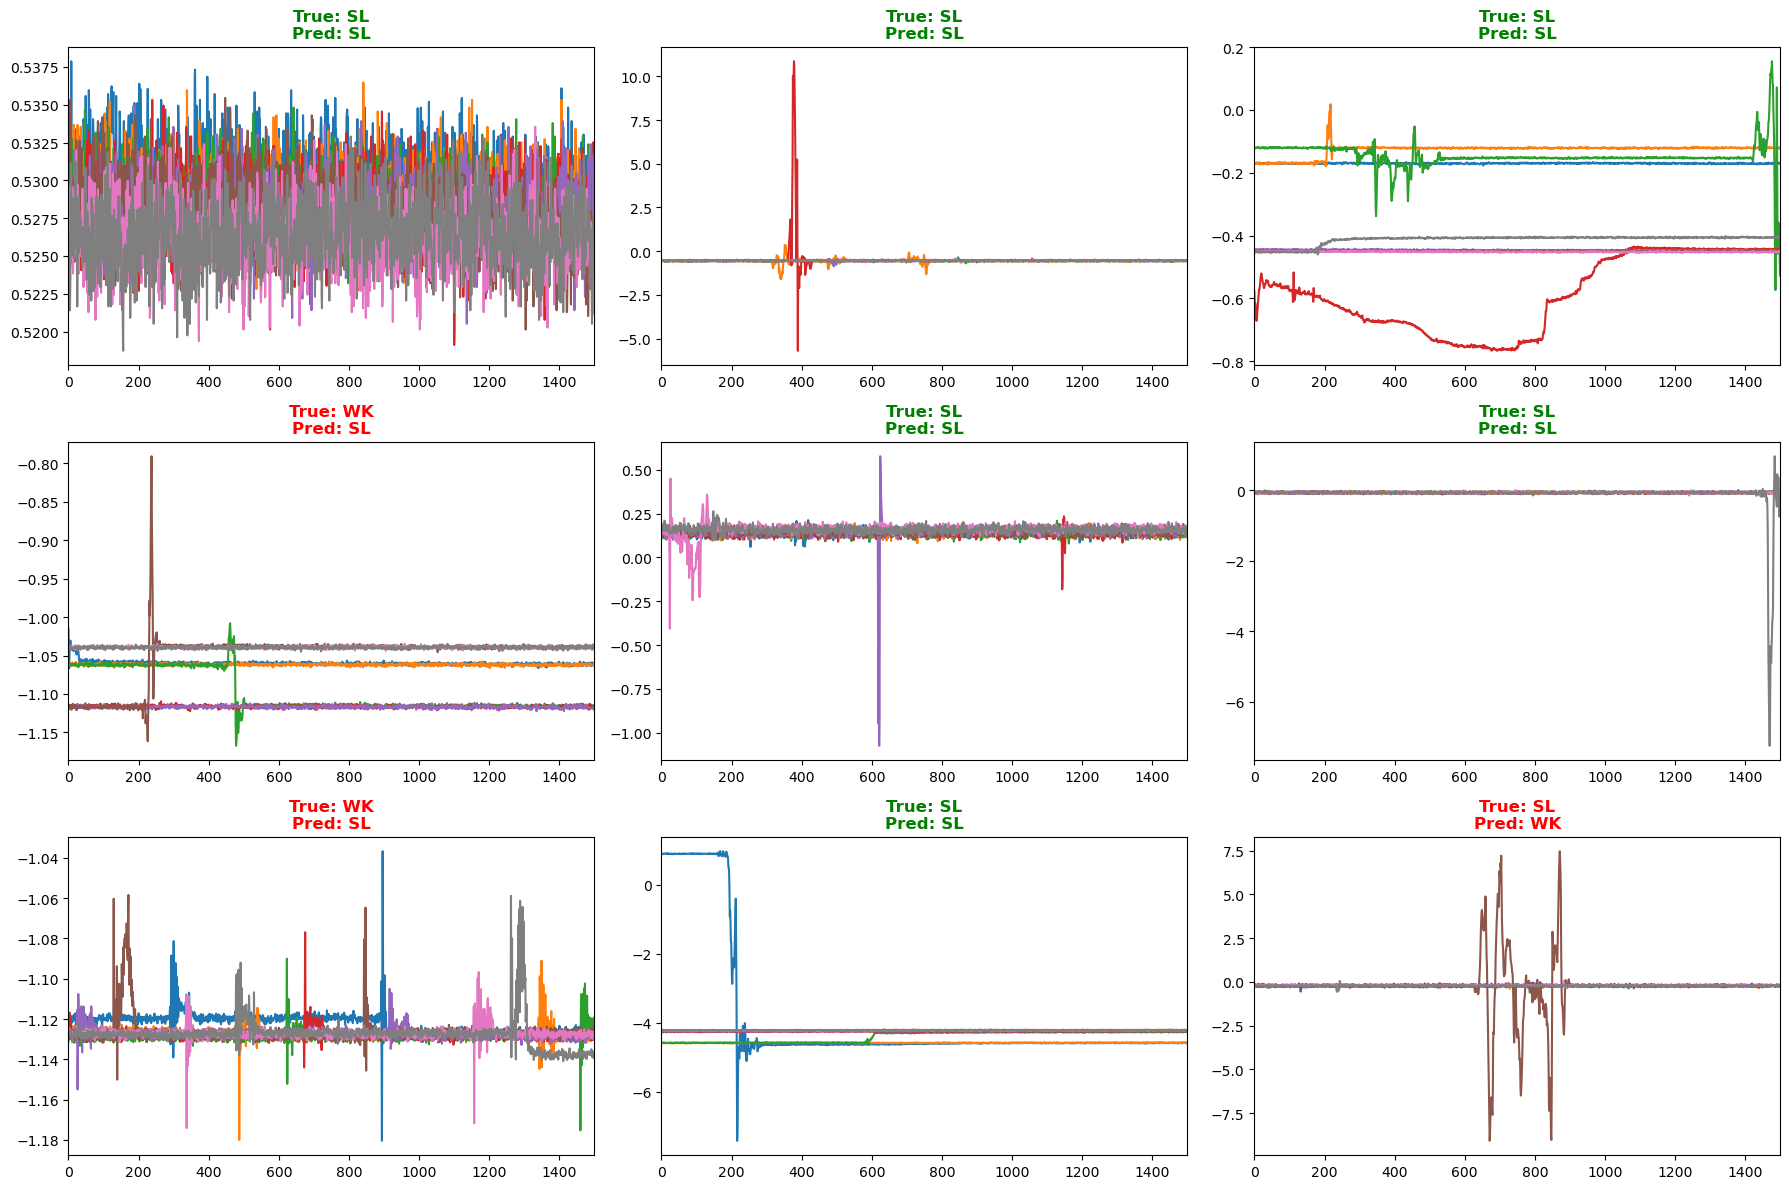

In [51]:
learn.show_results()


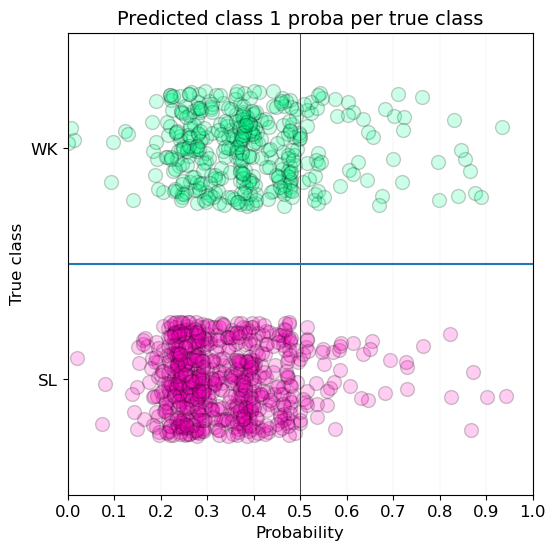

In [52]:
learn.show_probas()


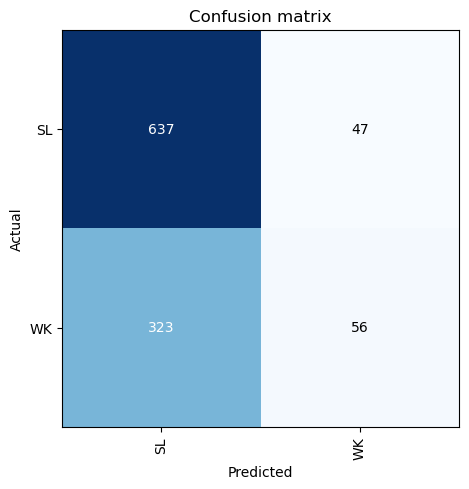

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [54]:
interp.most_confused(min_val=3)

[('WK', 'SL', 323), ('SL', 'WK', 47)]

In [55]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

accuracy:   0.651929


# inference on unseen data

In [56]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

# select the columns
test_data = test_data[['ledGreen', 'accelerometer', 'gyroscope', 'hr',
                'sleep_state']].interpolate(method='spline', order=4).dropna()

# drop rows where 'hr' column have values starting with '['
test_data = test_data[~test_data['hr'].str.startswith('[', na=False)]

test_data.reset_index(drop=True, inplace=True)

In [57]:
test_data

,ledGreen,accelerometer,gyroscope,hr,sleep_state
0,81.099061,4193.748204,227.129919,7.871621,0
1,448.425521,4188.334066,234.546904,6.814756,0
2,1158.939516,4182.935453,243.854465,6.344712,0
3,1915.355496,4185.416526,232.191731,6.601495,0
4,2313.691734,4187.903891,220.827987,7.252714,0
...,...,...,...,...,...
1726495,2.509672,4034.785744,263.024714,13.990475,1
1726496,5.263592,4036.533352,259.495665,13.193912,1
1726497,7.742607,4038.286023,257.631520,12.688979,1
1726498,9.844872,4038.391842,255.610381,12.523456,1


In [58]:
scaler = RobustScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data[['ledGreen', 'accelerometer', 'gyroscope', 'bpm', 'breathingrate', 'hr']])
y_test = le.fit_transform(test_data['sleep_state'])

pd.DataFrame(X_test)

KeyError: "['bpm', 'breathingrate'] not in index"

In [ ]:
# epoch lenght 60 seconds (25hz * 60 = 1500)
sh = len(X_test)//1500 

X_test = X_test.T.reshape(sh, 6, 1500)
y_test = y_test.T.reshape(sh, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

X_test.shape, y_test.shape

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(
    X_test, y_test)  # In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


In [ ]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

In [ ]:
learn.show_results()


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
